In [55]:
import glob
import pandas as pd
import geopandas as gpd
import numpy as np
import rasterio
from rasterio.plot import show
from scipy import ndimage
from matplotlib import pyplot
from math import pi

In [56]:
#Slope and Aspect Function
def slopeAspect(dem, cs):
    """Calculates slope and aspect using the 3rd-order finite difference method
    Parameters
    ----------
    dem : numpy array
        A numpy array of a DEM
    cs : float
        The cell size of the original DEM
    Returns
    -------
    numpy arrays
        Slope and Aspect arrays
    """
    kernel = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
    dzdx = ndimage.convolve(dem, kernel, mode='mirror') / (8 * cs)
    dzdy = ndimage.convolve(dem, kernel.T, mode='mirror') / (8 * cs)
    slp = np.arctan((dzdx ** 2 + dzdy ** 2) ** 0.5) * 180 / pi
    ang = np.arctan2(-dzdy, dzdx) * 180 / pi
    aspect = np.where(ang > 90, 450 - ang, 90 - ang)
    return slp, aspect

In [57]:
#Reclassify Aspect
def reclassAspect(npArray):
    """Reclassify aspect array to 8 cardinal directions (N,NE,E,SE,S,SW,W,NW),
    encoded 1 to 8, respectively (same as ArcGIS aspect classes).
    Parameters
    ----------
    npArray : numpy array
        numpy array with aspect values 0 to 360
    Returns
    -------
    numpy array
        numpy array with cardinal directions
    """
    return np.where((npArray > 22.5) & (npArray <= 67.5), 2,
    np.where((npArray > 67.5) & (npArray <= 112.5), 3,
    np.where((npArray > 112.5) & (npArray <= 157.5), 4,
    np.where((npArray > 157.5) & (npArray <= 202.5), 5,
    np.where((npArray > 202.5) & (npArray <= 247.5), 6,
    np.where((npArray > 247.5) & (npArray <= 292.5), 7,
    np.where((npArray > 292.5) & (npArray <= 337.5), 8, 1)))))))

In [58]:
#Reclass array function
def reclassByHisto(npArray, bins):
    """Reclassify np array based on a histogram approach using a specified
    number of bins. Returns the reclassified numpy array and the classes from
    the histogram.
    Parameters
    ----------
    npArray : numpy array
        Array to be reclassified
    bins : int
        Number of bins
    Returns
    -------
    numpy array
        umpy array with reclassified values
    """
    histo = np.histogram(npArray, bins)[1]
    rClss = np.zeros_like(npArray)
    for i in range(bins):
        rClss = np.where((npArray >= histo[i]) & (npArray <= histo[i + 1]),
                         i + 1, rClss)
    return rClss


In [59]:
#Open rasters, define variables
Elk_dem = rasterio.open(r'C:\Users\arom\Documents\School\Grad School\Fall 2020\Automation\lab5\data\data\bigElk_dem.tif')
fire_perimeter = rasterio.open(r'C:\Users\arom\Documents\School\Grad School\Fall 2020\Automation\lab5\data\data\fire_perimeter.tif')
forest_files = glob.glob(r'C:\Users\arom\Documents\School\Grad School\Fall 2020\Automation\lab5\data\data\L5_big_elk\*tif')

#Create arrays
dem_array = Elk_dem.read(1)
fire_array = fire_perimeter.read(1)

#Apply the given functions
slope, aspect = slopeAspect(dem_array, 30)
aspect_reclass = reclassAspect(aspect)
slope_reclass = reclassByHisto(slope, 10)

#Define red and infrared bands
red = glob.glob(r'C:\Users\arom\Documents\School\Grad School\Fall 2020\Automation\lab5\data\data\L5_big_elk\*B3.tif')
nir = glob.glob(r'C:\Users\arom\Documents\School\Grad School\Fall 2020\Automation\lab5\data\data\L5_big_elk\*B4.tif')
healthy = np.where(fire_array == 2)
burned = np.where(fire_array ==1)

#Create empty lists 
means = []
rr = []
years = ['2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011']

#Part I
for x,y in zip(red, nir):
    red = rasterio.open(x,'r').read(1)
    nir = rasterio.open(y,'r').read(1)
    ndvi = ((nir-red)/(nir+red))
    ndvi_mean = ndvi[healthy].mean()
    recovery_ratio = ndvi/ndvi_mean
    burn_mean = recovery_ratio[burned].mean()
    means.append(burn_mean)
    flat = recovery_ratio.ravel()
    rr.append(flat)
stacked_rr = np.vstack(rr)
line = np.polyfit(range(10), stacked_rr, 1)[0]
line_reshape = line.reshape(280, 459)
final_coefficient = np.where(fire_array==1, line_reshape, np.nan)
print('The coefficient of recovery across all years was', np.nanmean(final_coefficient))
for y,z in zip(years, means):
    print('The recovery ratio for', y, 'was', round(np.nanmean(z),5))

The coefficient of recovery across all years was 0.021795632717297512
The recovery ratio for 2002 was 0.41127
The recovery ratio for 2003 was 0.54127
The recovery ratio for 2004 was 0.51346
The recovery ratio for 2005 was 0.61525
The recovery ratio for 2006 was 0.71617
The recovery ratio for 2007 was 0.70541
The recovery ratio for 2008 was 0.73951
The recovery ratio for 2009 was 0.71263
The recovery ratio for 2010 was 0.5851
The recovery ratio for 2011 was 0.62589


In [60]:
#Part II
#Zonal stats function, slope and aspect csv files.
def zonal_stats_as_table(zone_raster, value_raster, output_csv):
    mean_stats = []
    st_dev = []
    mins = []
    maxs = []
    counts = []
    for i in np.unique(zone_raster):
        zone = np.where(zone_raster == i, i, np.nan)
        mean_stats.append(np.nanmean(zone * value_raster))
        st_dev.append(np.nanstd(zone * value_raster))
        mins.append(np.nanmin(zone * value_raster))
        maxs.append(np.nanmax(zone * value_raster))
        counts.append(np.where(zone_raster == i, 1, 0 ).sum())
    zonal_stats = {'Mean': mean_stats, 'Std. Dev.': st_dev, 'Min': mins, 'Max': maxs, 'Count': counts}
    df=pd.DataFrame(zonal_stats)
    df.to_csv(output_csv)
    return df
zonal_stats_as_table(slope_reclass, mean_coeficient, 'slope.csv')
zonal_stats_as_table(aspect_reclass, mean_coeficient, 'aspect.csv')

#Export tif
with rasterio.open(r'C:\Users\arom\Documents\School\Grad School\Fall 2020\Automation\lab5\data\data\bigElk_dem.tif') as dataset:
    with rasterio.open(f'final_coefficient.tif' , 'w',
                          driver='GTiff',
                          height=final_coefficient.shape[0],
                          width=final_coefficient.shape[1],
                          count=1,
                          dtype=final_coefficient.dtype,
                          crs=dataset.crs,
                            transform=dataset.transform,
                          nodta=dataset.nodata
                          ) as out_dataset:
        out_dataset.write(final_coefficient,1)

In [61]:
final_coefficient

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

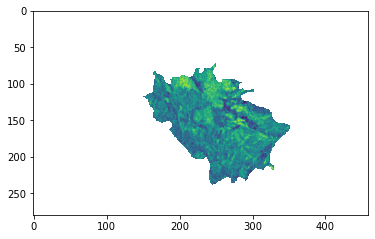

<AxesSubplot:>

In [62]:
with rasterio.open(r'C:\Users\arom\Documents\School\Grad School\Fall 2020\Automation\lab5\final_coefficient.tif') as dataset2:
    final_tif = dataset2.read(1)

show(final_tif)

In [63]:
print('Based on the aspect csv generated, the more S and SE aspects saw better recovery. In addition, the lower the slope, the better the recovery')

Based on the aspect csv generated, the more S and SE aspects saw better recovery. In addition, the lower the slope, the better the recovery
